- 训练集
  - normalized_images/train/pos里的图片作为正样本文件夹，其中图片大小为96 × 160的原因是图像周边有16 × 16的padding。所以读取图片时需截取中心64 × 128大小的部分，即坐标为(16,16)~(80,144)的部分。
  - 将normalized_images/train/neg作为负样本的文件夹，并且对于每个图片我们随机截取10个64 × 128的部分。
- 测试集
  - 将normalized_images/Test/pos作为测试正样本的文件夹，normalized_images/Test/neg为测试负样本的文件夹。

In [2]:
import cv2
import os
import numpy as np
from skimage import io
import random
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import joblib
import math


In [3]:
# 导入数据集
pos_dir = 'INRIADATA/normalized_images/train/pos'
neg_dir = 'INRIADATA/normalized_images/train/neg'
test_pos_dir = 'INRIADATA/normalized_images/test/pos'
test_neg_dir = 'INRIADATA/original_images/test/neg'

# 获取数据集中文件名列表
poslist = os.listdir(pos_dir)
neglist = os.listdir(neg_dir)
testlist = os.listdir(test_pos_dir)
testnlist = os.listdir(test_neg_dir)

In [4]:
hog_list = []
label_list = []
print("正样本图像有"+str(len(poslist)))
print("负样本原始图像有"+str(len(neglist))+"，每个原始图像提供十个负样本")

正样本图像有2416
负样本原始图像有1218，每个原始图像提供十个负样本


#### 提取单个图形HOG特征

In [5]:
def hog_descriptor(image):

    if (image.max()-image.min()) != 0:
        image = (image - image.min()) / (image.max() - image.min())
        image *= 255
        image = image.astype(np.uint8)


    hog = cv2.HOGDescriptor((64, 128), (16, 16), (8, 8), (8, 8), 9)
    hog_feature = hog.compute(image)

    return hog_feature


#### 读取数据集

In [6]:
# 读取正样本，设置正样本标签为1
for i in range(len(poslist)):
    posimg = io.imread(os.path.join(pos_dir, poslist[i]))
    posimg = cv2.cvtColor(posimg, cv2.COLOR_RGBA2BGR)
    # 所有·图像已经经过标准化
    posimg = cv2.resize(posimg, (64, 128), interpolation=cv2.INTER_NEAREST)
    pos_hog = hog_descriptor(posimg)
    hog_list.append(pos_hog)
    label_list.append(1) # 1为正样本

# 读取负样本，标签为0
for i in range(len(neglist)):
    negimg = io.imread(os.path.join(neg_dir, neglist[i]))
    negimg = cv2.cvtColor(negimg, cv2.COLOR_RGBA2BGR)

    #在每张negimg图像中截取10张标准大小的图片作为负样本
    for j in range(10):
        y = int(random.random() * (negimg.shape[0] - 128))
        x = int(random.random() * (negimg.shape[1] - 64))
        negimgs = negimg[y:y + 128, x:x + 64]
        negimgs = cv2.resize(negimgs, (64, 128), interpolation=cv2.INTER_NEAREST)
        neg_hog = hog_descriptor(negimgs)
        hog_list.append(neg_hog)
        label_list.append(0)



In [7]:
hog_list = np.float32(hog_list)
label_list = np.int32(label_list).reshape(len(label_list), 1)

#### SVM

In [8]:
clf = SVC(
    C = 1.0, # 正则化参数/惩罚系数。当C越大时，分类器的准确性越高，所以容错率越低，泛化能力就变差。当C越小时，分类器的准确性降低，但容错率增大，泛化能力越强
    gamma='auto',
    kernel='rbf',
    probability=True
)
clf.fit(hog_list.squeeze(), label_list.squeeze())
joblib.dump(clf, "trained_svm.model") # 保存训练好的模型


['trained_svm.model']

#### 测试集处理与提取

In [9]:
test_hog = []
test_label = []
# 测试集正样本
for i in range(len(testlist)):
    testimg = io.imread(os.path.join(test_pos_dir, testlist[i]))
    testimg = cv2.cvtColor(testimg, cv2.COLOR_RGBA2BGR)
    testimg = cv2.resize(testimg, (64, 128), interpolation=cv2.INTER_NEAREST)
    testhog = hog_descriptor(testimg)
    test_hog.append(testhog)
    test_label.append(1)

# 测试集负样本
for i in range(len(testnlist)):
    testnegimg = io.imread(os.path.join(test_neg_dir, testnlist[i]))
    testnegimg = cv2.cvtColor(testnegimg, cv2.COLOR_RGBA2BGR)

    #在每张negimg图像中截取10张标准大小的图片作为负样本
    for j in range(10):
        y = int(random.random() * (testnegimg.shape[0] - 128))
        x = int(random.random() * (testnegimg.shape[1] - 64))
        testnegimgs = testnegimg[y:y + 128, x:x + 64]
        testnegimgs = cv2.resize(testnegimgs, (64, 128), interpolation=cv2.INTER_NEAREST)
        testneg_hog = hog_descriptor(testnegimgs)
        test_hog.append(testneg_hog)
        test_label.append(0)

In [10]:
test_hog = np.float32(test_hog)
test_label = np.int32(test_label).reshape(len(test_label),1)
# 导入训练好的svm
clf = joblib.load("trained_svm.model")

#### ROC曲线

AUC: 0.98290751610538
AP: 0.9447056557989366


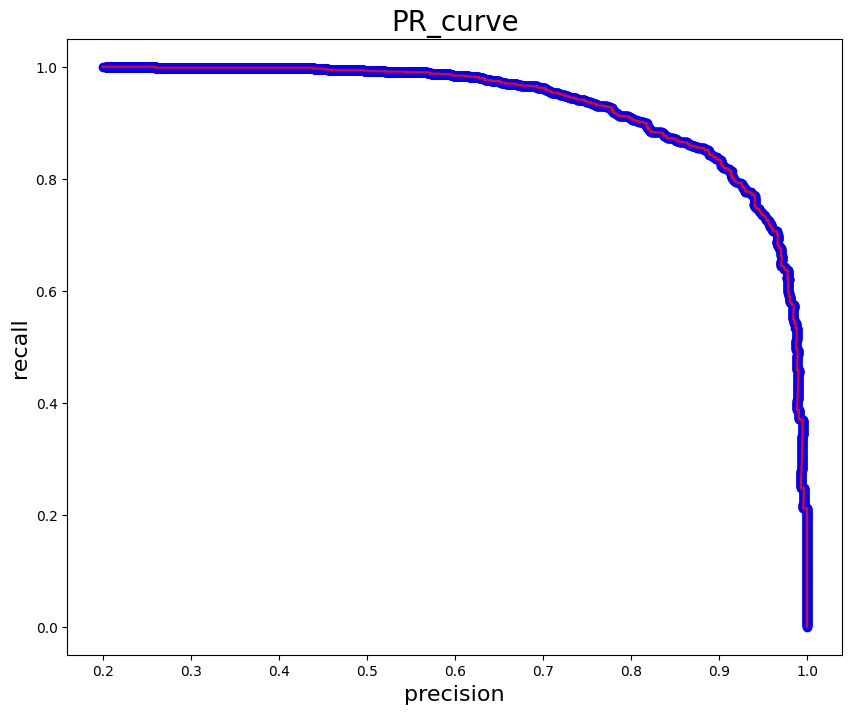

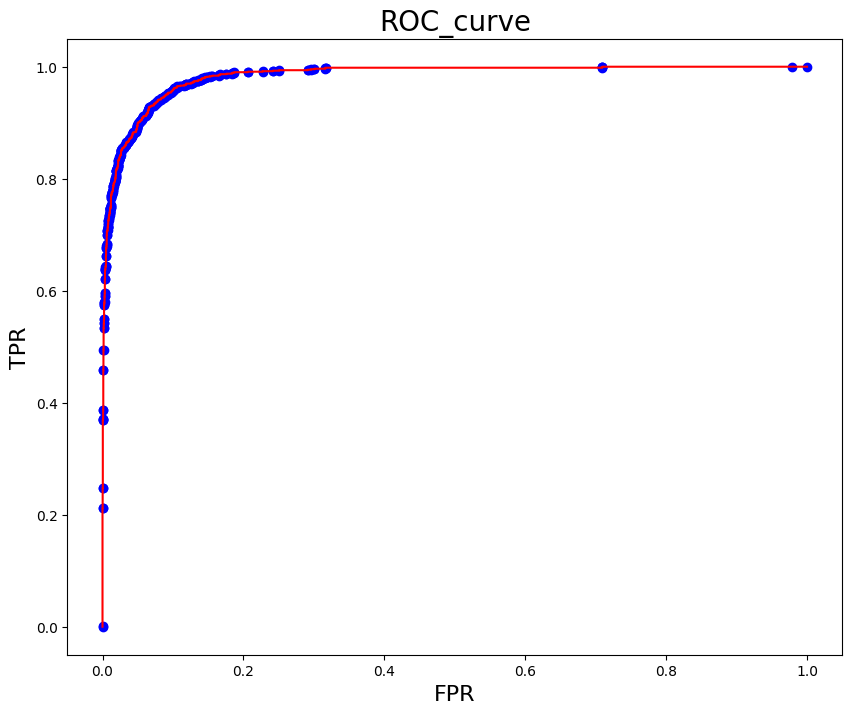

In [16]:
prob = clf.predict_proba(test_hog.squeeze())[:, 1]

precision, recall, thresholds_1 = metrics.precision_recall_curve(test_label.squeeze(), prob)

plt.figure(figsize=(10, 8))
plt.plot(precision, recall, c='red')
plt.scatter(precision, recall, c='blue')
plt.xlabel("precision", fontdict={'size': 16})
plt.ylabel("recall", fontdict={'size': 16})
plt.title("PR_curve", fontdict={'size': 20})
plt.savefig('PR.png')
Ap=metrics.average_precision_score(test_label.squeeze(), prob) # 平均精确率

fpr, tpr, thresholds_2 = metrics.roc_curve(test_label.squeeze(), prob, pos_label=1)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, c='red')
plt.scatter(fpr, tpr, c='blue')
plt.xlabel("FPR", fontdict={'size': 16})
plt.ylabel("TPR", fontdict={'size': 16})
plt.title("ROC_curve", fontdict={'size': 20})
plt.savefig('ROC.png')

AUC=metrics.roc_auc_score(test_label.squeeze(), prob)
print("AUC:", AUC)
print("AP:", Ap)


#### 给图像画框

In [14]:
import cv2
import os
import numpy as np
import os.path as osp
from skimage import io
import random
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import joblib
import math

def hog_descriptor(image):

    if (image.max()-image.min()) != 0:
        image = (image - image.min()) / (image.max() - image.min())
        image *= 255
        image = image.astype(np.uint8)


    hog = cv2.HOGDescriptor((64, 128), (16, 16), (8, 8), (8, 8), 9)
    hog_feature = hog.compute(image)

    return hog_feature

def mynms(box_list,prob_list,threshold=0.4):
    x1 = box_list[:,0]
    y1 = box_list[:,1]
    x2 = box_list[:,2]
    y2 = box_list[:,3]
    areas = (x2-x1+1)*(y2-y1+1)
    box_result = []
    flag = []
    index = prob_list.argsort()[::-1] #想要从大到小排序
    while index.size>0:
        i = index[0]
        flag.append(i)
        x11 = np.maximum(x1[i], x1[index[1:]])  # calculate the points of overlap
        y11 = np.maximum(y1[i], y1[index[1:]])
        x22 = np.minimum(x2[i], x2[index[1:]])
        y22 = np.minimum(y2[i], y2[index[1:]])
        w = np.maximum(0, x22 - x11 + 1)
        h = np.maximum(0, y22 - y11 + 1)
        overlaps = w * h
        ious = overlaps / (areas[i] + areas[index[1:]] - overlaps)
        #idx = np.where(ious < threshold)[0]
        index = np.delete(index,np.concatenate(([0],np.where(ious < threshold)[0])))
        #index = index[idx + 1]

    return box_list[flag].astype("int")


#首先通过Train中的标准的box大小计算出适合的box大小
box_list = []
ANN = os.listdir(r'INRIADATA\original_images\train\annotations')
flag = "(Xmax, Ymax)"
for i in range(len(ANN)):
    for line in open(r'INRIADATA\original_images\train\annotations/'+ANN[i],encoding="GBK"):
        if flag in line:
            boxsize  = line.split(flag)
            boxsize = str(boxsize[1])
            boxsize = boxsize.replace("(","")
            boxsize = boxsize.replace(",","")
            boxsize = boxsize.replace(")","")
            boxsize = boxsize.replace("-","")
            boxsize = boxsize.replace(":","")
            boxsize = boxsize.split()
            box = (float(boxsize[2])-float(boxsize[0]) ,float(boxsize[3])-float(boxsize[1]))
            box_list.append(box)
box_list = np.array(box_list)
minlist = np.min(box_list,axis=0)
maxlist = np.max(box_list,axis=0)

"""
print(minlist)
print(maxlist)
"""
minscale = min(minlist[0]/64,minlist[1]/128)
maxscale = min(maxlist[0]/64,maxlist[1]/128)

"""
print(minscale)
print(maxscale)
"""

minscale = math.ceil(minscale)
maxscale = math.ceil(maxscale)
print(minscale)
print(maxscale)
clf = joblib.load("trained_svm.model")

imglist = os.listdir('INRIADATA/original_images/test/pos')
for i in range(101,len(imglist)):
    img = io.imread(osp.join('INRIADATA/original_images/test/pos', imglist[i]))
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    h,w,c= img.shape
    patch_list = []
    hog_feature = []
    box_list = []
    for j in range(minscale,maxscale+1,1):
        winsize = [j*64,j*128]
        for m in range(0,h-winsize[1],20):
            for n in range(0,w-winsize[0],20):
                patch = img[m:m+winsize[1],n:n+winsize[0]]
                patch = cv2.resize(patch, (64,128), interpolation = cv2.INTER_NEAREST)
                boxcoord = (m,n,m+winsize[1],n+winsize[0])
                hogfea = hog_descriptor(patch)
                hog_feature.append(hogfea)
                box_list.append(boxcoord)
                patch_list.append(patch)
    hog_feature = np.array(hog_feature).squeeze()
    box_list = np.array(box_list)
    prob = clf.predict_proba(hog_feature)[:, 1]
    mask = (prob>= 0.99)
    box_list = box_list[mask]
    prob = prob[mask]
    boxzhong = mynms(box_list,prob)

    for k in range(len(boxzhong)):
        cv2.rectangle(img, (boxzhong[k][1], boxzhong[k][0]), (boxzhong[k][3], boxzhong[k][2]),(0, 0, 255),3)
    cv2.imwrite('result/'+imglist[i]+".jpg",img)
    print(str(i))
    if i == 150:
        break

print("结束")


1
7
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
结束


In [ ]:
def area_of_box(box):
    '''
    计算框的面积。

    参数
    ---
    box: 框，格式为(left, top, width, height)。

    返回值
    -----
    box的面积，即width * height。
    '''
    return box[2] * box[3]

def intersection_over_union(box1, box2):
    '''
    两个框的交并比（IoU）。

    参数
    ---
    box1: 边框1。
    box2: 边框2。
    '''
    intersection_width = max(0,
        box1[0] + box1[2] - box2[0])
        # 相交部分宽度=max(0, box1的右边 - box2的左边)
    intersection_height = max(0,
        box1[1] + box1[3] - box2[1])
        # 相交部分长度=max(0, box1的下边 - box2的上边)
    intersection_area = intersection_width * \
        intersection_height # 相交部分面积
    area_box1 = area_of_box(box1) # box1的面积
    area_box2 = area_of_box(box2) # box1的面积
    union_area = area_box1 + area_box2 - \
        intersection_area
    if abs(union_area) < 1:
        IoU = 0 # 防止除以0
    else:
        IoU = intersection_area / union_area
            # 并集的面积等于二者面积之和减去交集的面积
    return IoU

def non_maximum_suppression(pos_box_list, pos_prob,
    IoU_threshold=0.4):
    '''
    非极大值抑制（NMS）。

    参数
    ---
    pos_box_list: 含有人的概率大于阈值的边框列表。
    pos_prob: 对应的概率。
    IoU_threshold: 舍弃边框的IoU阈值。

    返回值
    -----
    抑制后的边框列表。
    '''
    result = [] # 结果
    for box1, prob1 in zip(pos_box_list, pos_prob):
        discard = False # 是否舍弃box1
        for box2, prob2 in zip(
            pos_box_list, pos_prob):
            if intersection_over_union(
                box1, box2) > IoU_threshold:
                # IoU大于阈值
                if prob2 > prob1: # 舍弃置信度较小的
                    discard = True
                    break
        if not discard: # 未舍弃box1
            result.append(box1) # 加入结果列表
    return result

def detect_pedestrian(SVM, filename, show_img=False,
    threshold=0.99, area_width=64, area_height=128,
    min_width=48, width_scale=1.25, coord_step=16,
    ratio=2):
    '''
    用SVM检测file文件中的行人，采用非极大值抑制（NMS）
    避免重复画框。

    参数
    ---
    SVM: 训练好的SVM模型。
    filename: 输入文件名。
    show_img: 是否给用户显示已画框的图片。
    threshold: 将某一部分视为人的概率阈值。
    area_width: 缩放后区域的宽度。
    area_height: 缩放后区域的高度。
    min_width: 框宽度的最小值，也是初始值。
    width_scale: 每一次框宽度增大时扩大的倍数。
    coord_step: 坐标变化的步长。
    ratio: 框的长宽比。

    返回值
    -----
    一个列表，每个列表项是一个元组
    (left, top, width, height), 为行人的边框。
    '''
    box_list = [] # 行人边框列表
    hog_list = [] # HOG特征列表
    with open(filename, 'rb') as file:
        img = imread(file, as_gray=True) # 读取文件
        img_height, img_width = img.shape # 图片长宽
        width = min_width # 框的宽度
        height = int(width * ratio) # 框的长度
        while width < img_width and height < img_height:
            for left in range(0, img_width - width,
                coord_step): # 框的左侧
                for top in range(0, img_height - height,
                    coord_step): # 框的上侧
                    patch = clip_image(img, left, top,
                        width, height) # 截取图像的一部分
                    resized = resize(patch,
                        (area_height, area_width))
                        # 缩放图片
                    hog_feature = extract_hog_feature(
                        resized) # 提取HOG特征
                    box_list.append((left, top,
                        width, height))
                    hog_list.append(hog_feature)
            width = int(width * width_scale)
            height = width * ratio
        prob = SVM.predict_proba(hog_list)[:, 1]
            # 用SVM模型进行判断
        mask = (prob >= threshold)
            # 布尔数组, mask[i]代表prob[i]是否等于阈值
        pos_box_list = np.array(box_list)[mask]
            # 含有人的框
        pos_prob = prob[mask] # 对应的预测概率
        box_list_after_NMS = non_maximum_suppression(
            pos_box_list, pos_prob)
            # NMS处理之后的框列表
        if show_img:
            shown_img = np.array(img)
                # 复制原图像，准备画框
            for box in box_list_after_NMS:
                shown_img = rectangle(shown_img,
                    pt1=(box[0], box[1]),
                    pt2=(box[0] + box[2],
                        box[1] + box[3]),
                    color=(0, 0, 0),
                    thickness=2)
            imshow('', shown_img)
            waitKey(0)
        return box_list_after_NMS

def detect_multiple_images(SVM, dir):
    '''
    检测多个图像文件（dir文件夹中所有文件）中的行人。

    参数
    ---
    SVM: 训练好的SVM模型。
    dir: 存放图片的文件夹。
    '''
    files = os.listdir(dir)
    for file in files:
        file_path = os.path.join(dir, file)
        detect_pedestrian(SVM, file_path,
            show_img=True)
